<a href="https://colab.research.google.com/github/ejrtks1020/Computer_Vision_Project/blob/main/Dacon_%EB%B3%91%EB%B3%80_%EA%B2%80%EC%B6%9C_(Yolov5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 병변 검출 AI 경진대회

## 의료 현장에서 촬영되는 캡슐 내시경 이미지 데이터셋

## 데이터 구조
1. train - 학습용 json 파일 62622개

	├ train_100000.json

	│	├ file_name : 파일 이름

	│	├ shape : 객체별 label 및 객체 위치 정보

	│	│	├ label : 객체 이름

	│	│	├ points : 객체의 4개 꼭지점(x, y) 좌표 정보

	│	│	├ label : 객체 이름

	│	│	├ points : 객체의 4개 꼭지점(x, y) 좌표 정보

	│	│	├ ...

	│	├ imageData : base64형식 이미지 데이터

	│	├ imageHeight : 이미지 세로 길이

	│	└ imageWidth : 이미지 가로 길이

	├ train_100001.json

	├ train_100002.json

	├ ...



2. test - 평가용 json 파일 20874개

	├ test_200000.json

	│	├ file_name : 파일 이름

	│	├ imageData : base64형식 이미지 데이터

	│	├ imageHeight : 이미지 세로 길이

	│	└ imageWidth : 이미지 가로 길이

	├ test_200001.json

	├ test_200002.json

	├ ...



3. class_id.csv - 객체별 제출 id정보

class : 객체이름
class_id : 객체 id

#1. Ultralytics Yolov5 설치

In [1]:
# Clone and install YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt
%cd ..

Cloning into 'yolov5'...
remote: Enumerating objects: 10843, done.
remote: Total 10843 (delta 0), reused 0 (delta 0), pack-reused 10843
Receiving objects: 100% (10843/10843), 10.92 MiB | 21.76 MiB/s, done.
Resolving deltas: 100% (7492/7492), done.
/content/yolov5
     |████████████████████████████████| 596 kB 12.9 MB/s 
/content


In [2]:
!mkdir dacon

In [ ]:
!unzip '/content/drive/MyDrive/데이콘 병변 검출/235855_병변 검출 AI 경진대회_data.zip' -d /content/dacon

# 2. 데이터 탐색

In [35]:
import json
import glob
import cv2
import numpy as np
import io
import matplotlib.pyplot as plt
import base64
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
import json
with open('/content/dacon/train/train_100000.json', 'r') as f:
  json_data = json.load(f)
print(json.dumps(json_data))

### 하나의 학습 데이터는 json 포맷으로 bounding box 좌표와 인코딩된 이미지를 포함

In [ ]:
print(json.dumps(json_data, indent = '\t'))

In [ ]:
# base64로 인코딩된 이미지 데이터
json_data['imageData']

# 2.1. 인코딩된 이미지를 디코딩 후 시각화

In [ ]:
import base64
import io
import cv2
import numpy as np
from PIL import Image
img_data=base64.b64decode(json_data['imageData'])
print(img_data)
dataBytesIO = io.BytesIO(img_data)
print(dataBytesIO)
image = Image.open(dataBytesIO)
print(image)
img = np.array(image)

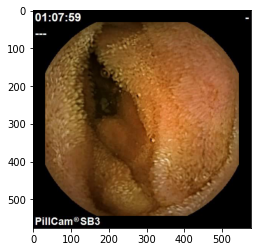

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img);

# 2.2. 전체 학습데이터를 학습데이터와 검증데이터로 분리

In [5]:
train_img_list = sorted(glob.glob('/content/dacon/train/*.json'))

In [6]:
test_img_list = sorted(glob.glob('/content/dacon/test/*.json'))

In [ ]:
train_img_list[:10]

['/content/dacon/train/train_100000.json',
 '/content/dacon/train/train_100001.json',
 '/content/dacon/train/train_100002.json',
 '/content/dacon/train/train_100003.json',
 '/content/dacon/train/train_100004.json',
 '/content/dacon/train/train_100005.json',
 '/content/dacon/train/train_100006.json',
 '/content/dacon/train/train_100007.json',
 '/content/dacon/train/train_100008.json',
 '/content/dacon/train/train_100009.json']

In [ ]:
len(train_img_list)

62622

### 시간과 제한적인 메모리 환경을 고려하여 전체 학습데이터(62622개)중 20000개만 학습에 사용

In [7]:
from sklearn.model_selection import train_test_split
tr_imgs, val_imgs = train_test_split(train_img_list, test_size = 0.15, random_state = 2022)
len(tr_imgs), len(val_imgs)

(53228, 9394)

In [ ]:
 tr_imgs_2 = tr_imgs[:20000]

In [8]:
!mkdir dacon_yolo
!mkdir /content/dacon_yolo/images; mkdir /content/dacon_yolo/labels
!mkdir /content/dacon_yolo/images/train; mkdir /content/dacon_yolo/images/val
!mkdir /content/dacon_yolo/labels/train; mkdir /content/dacon_yolo/labels/val

In [9]:
import pandas as pd

class_id = pd.read_csv('/content/dacon/class_id_info.csv')
class_id.head()

,class,class_id
0,01_ulcer,1
1,02_mass,2
2,04_lymph,3
3,05_bleeding,4


In [10]:
CLASS_NAMES = ['01_ulcer', '02_mass', '04_lymph', '05_bleeding']

## Yolo format annotation 생성

In [11]:
# base64로 인코딩된 이미지를 디코딩해서 이미지를 반환하는 함수
def decode_base64_to_img(encoded_img):
  img_data=base64.b64decode(encoded_img)
  dataBytesIO = io.BytesIO(img_data)
  image = Image.open(dataBytesIO)
  img = np.array(image)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  return img

In [12]:
# bounding box 좌표를 yolo format(중심좌표와 너비, 높이)로 변환하는 함수
def convert_yolo_coord(object_name, img_width, img_height, x1, y1, x2, y2):
  # class_id는 CLASS_NAMES 리스트에서 index 번호로 추출.
  class_id = CLASS_NAMES.index(object_name)
  # 중심 좌표와 너비, 높이 계산. 
  center_x = (x1 + x2)/2
  center_y = (y1 + y2)/2
  width = x2 - x1
  height = y2 - y1
  # 원본 이미지 기준으로 중심 좌표와 너비 높이를 0-1 사이 값으로 scaling
  center_x_norm = center_x / img_width
  center_y_norm = center_y / img_height
  width_norm = width / img_width
  height_norm = height / img_height

  return class_id, round(center_x_norm, 7), round(center_y_norm, 7), round(width_norm, 7), round(height_norm, 7)

In [13]:
def json_to_txt(json, txt_path):
  h = int(json['imageHeight'])
  w = int(json['imageWidth'])

  object_name = json['shapes'][0]['label']

  x1, y1 = map(int, json['shapes'][0]['points'][0])
  x2, y2 = map(int, json['shapes'][0]['points'][2])

  class_id, cx_norm, cy_norm, bbw_norm, bbh_norm = convert_yolo_coord(object_name, w, h, x1, y1, x2, y2)

  with open(txt_path, 'w') as output_fpointer:
    #변환된 yolo 좌표를 object별로 출력 text 파일에 write
    value_str = ('{0} {1} {2} {3} {4}').format(class_id, cx_norm, cy_norm, bbw_norm, bbh_norm)
    output_fpointer.write(value_str + '\n')


일부 json 데이터를 jpg 및 txt파일로 변환

In [ ]:
#destination directory
imgs_dir = '/content/dacon_yolo/images/train'
labels_dir = '/content/dacon_yolo/labels/train'
for json_path in tr_imgs[:5]:
  with open(json_path, 'r') as f:
    json_data = json.load(f)
    print(json_path)
    encoded_img = json_data['imageData']

    img = decode_base64_to_img(encoded_img)
    img_path = os.path.join(imgs_dir, json_path.split('/')[-1].replace('.json', '.jpg'))
    cv2.imwrite(img_path, img)
    print(img_path)
    txt_path = os.path.join(labels_dir, json_path.split('/')[-1].replace('.json', '.txt'))
    json_to_txt(json_data, txt_path)
    print(txt_path)

/content/dacon/train/train_131281.json
/content/dacon_yolo/images/train/train_131281.jpg
/content/dacon_yolo/labels/train/train_131281.txt
/content/dacon/train/train_137909.json
/content/dacon_yolo/images/train/train_137909.jpg
/content/dacon_yolo/labels/train/train_137909.txt
/content/dacon/train/train_150732.json
/content/dacon_yolo/images/train/train_150732.jpg
/content/dacon_yolo/labels/train/train_150732.txt
/content/dacon/train/train_128057.json
/content/dacon_yolo/images/train/train_128057.jpg
/content/dacon_yolo/labels/train/train_128057.txt
/content/dacon/train/train_110516.json
/content/dacon_yolo/images/train/train_110516.jpg
/content/dacon_yolo/labels/train/train_110516.txt


In [14]:
def json_to_jpg_txt(src_json_path, dst_img_dir, dst_annot_dir):
  with open(src_json_path, 'r') as f:
    json_data = json.load(f)
    encoded_img = json_data['imageData']

    img = decode_base64_to_img(encoded_img)
    img_path = os.path.join(dst_img_dir, src_json_path.split('/')[-1].replace('.json', '.jpg'))
    cv2.imwrite(img_path, img)
    if 'test' not in src_json_path:
      txt_path = os.path.join(dst_annot_dir, src_json_path.split('/')[-1].replace('.json', '.txt'))
      json_to_txt(json_data, txt_path)

In [ ]:
!mkdir /content/dacon_yolo/images/test; mkdir /content/dacon_yolo/labels/test

In [ ]:
# 학습데이터 생성
dst_img_dir = '/content/dacon_yolo/images/train'
dst_annot_dir = '/content/dacon_yolo/labels/train'
for src_json in tr_imgs_2:
  json_to_jpg_txt(src_json, dst_img_dir, dst_annot_dir)

In [16]:
# 검증데이터 생성
dst_img_dir = '/content/dacon_yolo/images/val'
dst_annot_dir = '/content/dacon_yolo/labels/val'
for src_json in val_imgs:
  json_to_jpg_txt(src_json, dst_img_dir, dst_annot_dir)

In [15]:
# 테스트 데이터 생성
dst_img_dir = '/content/dacon_yolo/images/test'
dst_annot_dir = '/content/dacon_yolo/labels/test'
for src_json in test_img_list:
  json_to_jpg_txt(src_json, dst_img_dir, dst_annot_dir)

# 3. 병변 데이터 학습수행
## 메모리 문제 때문에 img size는 256, batch는 4, epoch을 30으로 설정

In [ ]:
!python yolov5/train.py --img 256 --batch 4 --epochs 30 \
--data '/content/dacon_yolo/dacon.yaml' \
--weights yolov5/yolov5s.pt --cache \
--project '/content/drive/MyDrive/데이콘 병변 검출' --name dacon --exist-ok

train: weights=yolov5/yolov5s.pt, cfg=, data=/content/dacon_yolo/dacon.yaml, hyp=yolov5/data/hyps/hyp.scratch.yaml, epochs=30, batch_size=4, imgsz=256, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/content/drive/MyDrive/데이콘 병변 검출, name=dacon, exist_ok=True, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.0-227-gcb40c9a torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=

### iou Thresh old가 0.5일때 mAP는 0.623, 0.5~ 0.95일때는 0.306으로 낮은 성능을 보인다. 

* 학습데이터를 더 늘리거나 입력 이미지 사이즈와 epoch을 늘린다면 더 좋은 성능을 보일것으로 예상됨

# 4. 이미지 Detection 수행

## 4.1. Validation Ground Truth 이미지 시각화

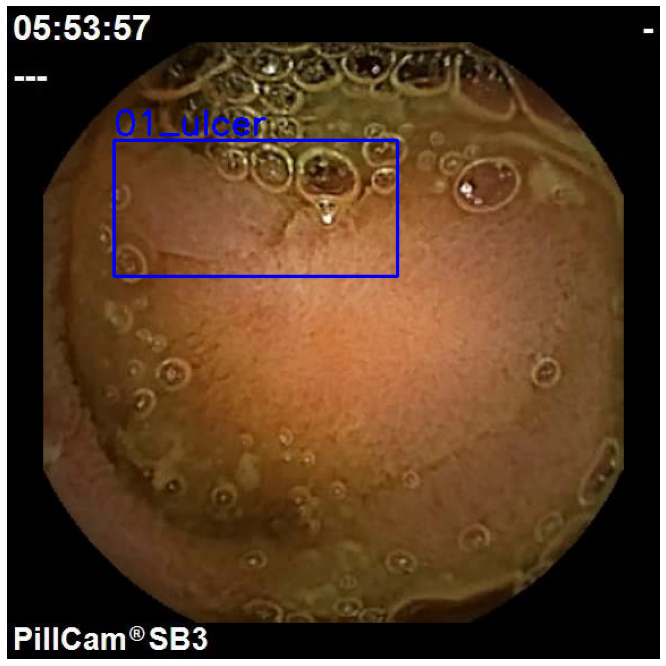

In [57]:
val_data = val_imgs[0].split('/')[-1][:-5]

val_img_dir = '/content/dacon_yolo/images/val'
val_txt_dir = '/content/dacon_yolo/labels/val'

val_img = os.path.join(val_img_dir, val_data + '.jpg')
val_annot = os.path.join(val_txt_dir, val_data + '.txt')

img = cv2.imread(val_img)
h, w = img.shape[:2]

CLASS_NAMES = ['01_ulcer', '02_mass', '04_lymph', '05_bleeding']

COLOR_LIST = [(255, 0, 0),
              (0, 255, 0),
              (0, 0, 255),
              (120, 255, 0)]

with open(val_annot, 'r') as f:
  for line in f:
    l = list(map(float, line.strip('\n').split(' ')))
    # yolo data format은 bounding box의 중심좌표(l[1], l[2])와 박스의 너비와 높이(l[3], l[4])로 저장되어 있으며 이미지 크기를 기준으로 0 ~ 1사이 값으로 scaling 되어있음
    # 따라서 width와 height를 곱해서 원래값을 구한다.
    center_x, center_y = int(l[1] * w), int(l[2] * h)  
    box_w, box_h = int(l[3] * w), int(l[4] * h)

    # opencv로 bounding box를 그리기 위해 좌상단, 우하단 좌표를 계산
    left = int(center_x - (box_w / 2))
    top = int(center_y - (box_h / 2))
    right = int(left + box_w)
    bottom = int(top + box_h)

    # 레이블(l[0]) 값에따라 박스와 caption의 색을 지정
    class_id = int(l[0])
    color = COLOR_LIST[class_id]
    caption = CLASS_NAMES[class_id]

    cv2.rectangle(img, (left,top), (right, bottom), color = color, thickness = 2)
    cv2.putText(img, caption, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX,1, color, 2)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')
plt.show()


In [29]:
!mkdir detect_output
!mkdir val_images

## 4.2. 일부 Validation 데이터 inference

In [43]:
# 이미지에 바운딩 박스를 추가하는 함수
def draw_box(img, annot):
  h, w = img.shape[:2]
  with open(annot, 'r') as f:
    for line in f:
      l = list(map(float, line.strip('\n').split(' ')))
      center_x, center_y = int(l[1] * w), int(l[2] * h)
      box_w, box_h = int(l[3] * w), int(l[4] * h)

      left = int(center_x - (box_w / 2))
      top = int(center_y - (box_h / 2))
      right = int(left + box_w)
      bottom = int(top + box_h)

      class_id = int(l[0])
      color = COLOR_LIST[class_id]
      caption = CLASS_NAMES[class_id]

      cv2.rectangle(img, (left,top), (right, bottom), color = color, thickness = 2)
      cv2.putText(img, caption, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

  return img

In [47]:
val_images = glob.glob('/content/dacon_yolo/images/val/*.jpg')[:8]
val_labels = [i.replace('.jpg', '.txt').replace('images', 'labels') for i in val_images]

In [48]:
dst = '/content/val_images'
for src_img in val_images:
  dst_img = os.path.join(dst, src_img.split('/')[-1])
  shutil.copy(src_img, dst_img)

for src_label in val_labels:
  dst_label = os.path.join(dst, src_label.split('/')[-1])
  shutil.copy(src_label, dst_label)

In [49]:
!python yolov5/detect.py --weights '/content/drive/MyDrive/데이콘 병변 검출/dacon/weights/best.pt' \
--conf 0.25 --source /content/val_images --project detect_output

detect: weights=['/content/drive/MyDrive/데이콘 병변 검출/dacon/weights/best.pt'], source=/content/val_images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=detect_output, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-232-g079b36d torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/8 /content/val_images/train_115770.jpg: 640x640 1 01_ulcer, 1 05_bleeding, Done. (0.010s)
image 2/8 /content/val_images/train_118084.jpg: 640x640 1 04_lymph, Done. (0.011s)
image 3/8 /content/val_images/train_123776.jpg: 640x640 1 05_bleeding, Done. (0.010s)
image 4/8 /content/val_images/train_133459.jpg: 64

In [55]:
COLOR_LIST = [(255, 0, 0),
              (0, 255, 0),
              (0, 0, 255),
              (120, 255, 0)]

## detection 결과 시각화

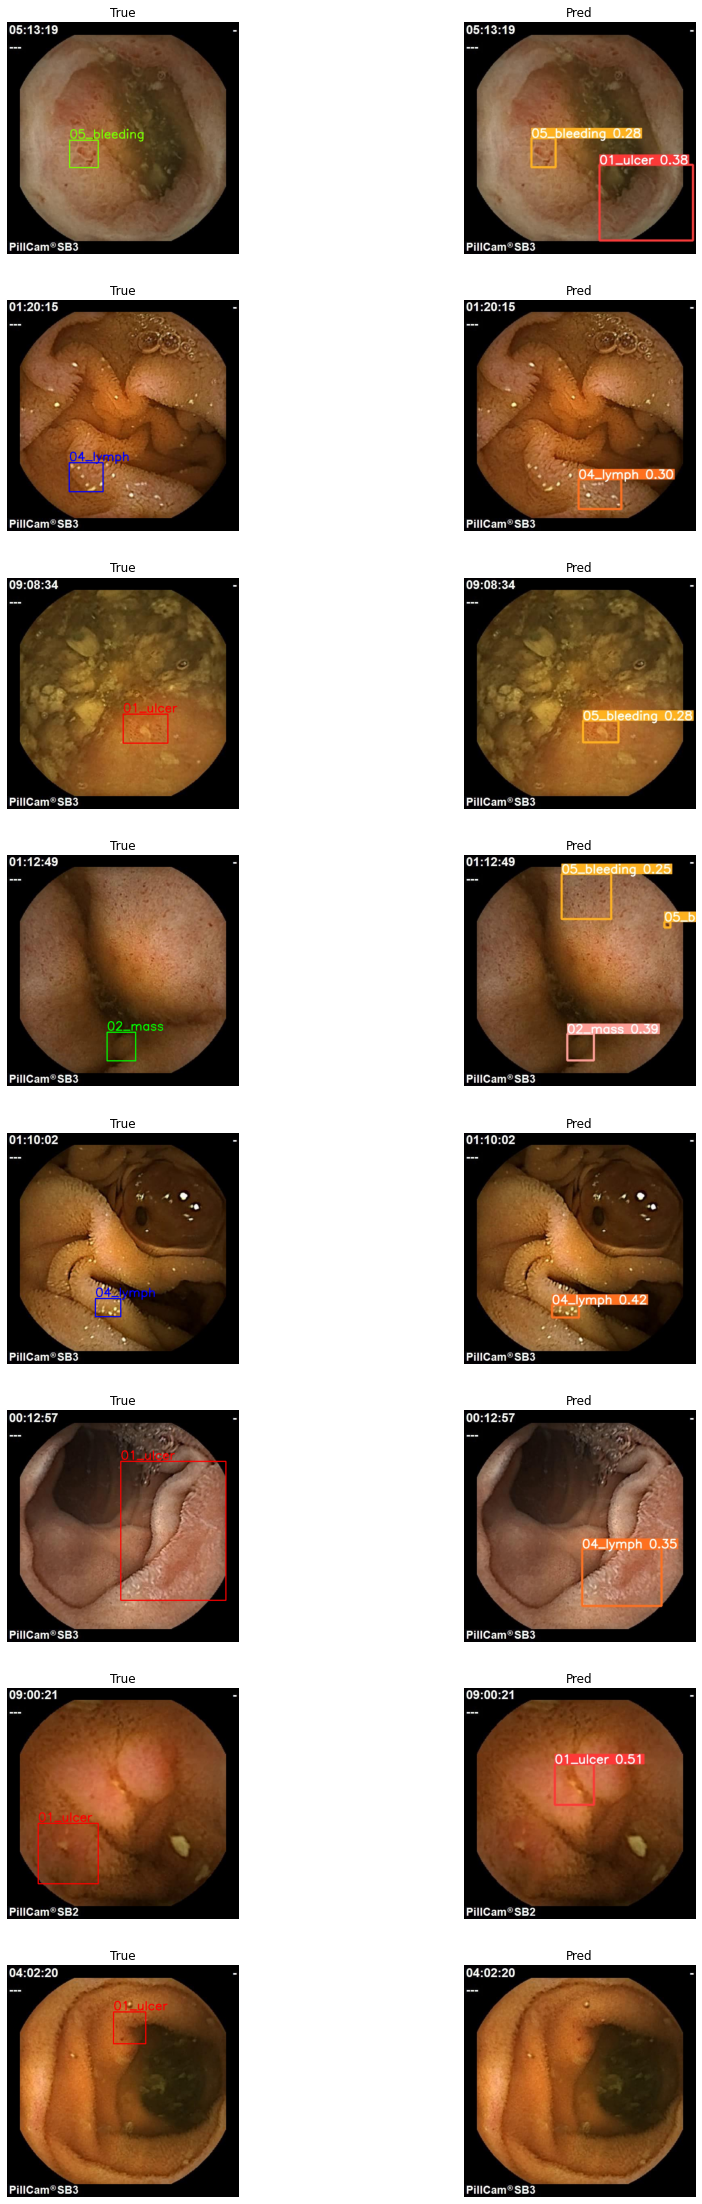

In [56]:
gt_imgs = sorted(glob.glob('/content/val_images/*.jpg'))
gt_labels = sorted(glob.glob('/content/val_images/*.txt'))
pred_imgs = sorted(glob.glob('/content/detect_output/exp2/*.jpg'))

fig, ax = plt.subplots(8, 2, figsize = (15, 40))

for i in range(len(gt_imgs)):
  gt_img = cv2.cvtColor(cv2.imread(gt_imgs[i]), cv2.COLOR_BGR2RGB)
  gt_bbox_img = draw_box(gt_img, gt_labels[i])
  ax[i, 0].imshow(gt_bbox_img)
  ax[i, 0].set_title('True')
  ax[i, 0].axis('off')

  pred_img = cv2.cvtColor(cv2.imread(pred_imgs[i]), cv2.COLOR_BGR2RGB)
  ax[i, 1].imshow(pred_img)
  ax[i, 1].set_title('Pred')
  ax[i, 1].axis('off')